In [406]:
#!/usr/bin/python3
# coding: -*- utf-8 -*-
# MHLW

In [426]:
import chardet
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel
import sys
from twitter import Twitter, OAuth
from urllib.request import urlretrieve
import yaml

In [427]:
# 統計開始日時
dt_offset = "2020/1/16"

In [428]:
def csv2array(arr, k, filename, idx):
    """ CSVをnp arrayに変換する """
    from_date = dt.strptime(dt_offset, "%Y/%m/%d")
    
    default_enc = "shift-jis"
    with open(filename, "rb") as f:
        enc = chardet.detect(f.readline())
        print("file: {} enc: {}".format(filename, enc['encoding']))
        if enc['encoding'] is not None:
            default_enc = enc['encoding']
    
    with codecs.open(filename, encoding=default_enc) as f:
        l = f.readline()
        while l:
            l = f.readline().replace("\r\n", "")
            elems = l.split(',')
            if len(elems) > 1:
                delta = dt.strptime(elems.pop(0), "%Y/%m/%d") - from_date
                cnt = 0
                for elem in elems:
                    arr[delta.days][cnt + idx] = blank2zero(elem)
                    cnt += 1
                if k == 'pcr':
                    daily_total = 0
                    for elem in elems:
                        daily_total += blank2zero(elem)
                    arr[delta.days][idx + cnt] = daily_total
    pass

In [429]:
def blank2zero(code):
    """ 空文字を0に変換する """
    if len(code) == 0:
        return 0
    return int(code)


In [430]:
def tweet_with_image(twtr, filename, msg):
    print(msg)
    with open(filename, "rb") as imagefile:
        imagedata = imagefile.read()
        params = {"media[]": imagedata, "status": msg}
        req = twtr.statuses.update_with_media(**params)
        print(req['created_at'])
    print("Tweeted.")


In [431]:
# 厚労省の OpenData を参照する
base_uri = "https://www.mhlw.go.jp/content/"

raws = dict(
    posis = "pcr_positive_daily.csv",
    tests = "pcr_tested_daily.csv",
    cases = "cases_total.csv",
    recov = "recovery_total.csv",
    death = "death_total.csv",
    pcr = "pcr_case_daily.csv")

offsets = dict(
    dates = 0, # 日付オフセット
    cases = 1, # 入院治療を要する者(Total)
    death = 2, # 死亡者数(Total)
    pcr   = 3, # PCR検査 件数：感染研、検疫、保健所、民間、大学、医療機関(Daily), 小計
    posis = 10, # 陽性者数(Daily)
    tests = 11, # PCR検査 人数(Daily)
    recov = 12, # 退院（Total)
    ratio = 13, # 陽性率(Daily) = 陽性者数 / 検査人数
    total = 14, # 陽性者数(Total)
    ) # 

# 集計期間
dt_range = (dt.today() - dt.strptime(dt_offset, "%Y/%m/%d")).days
# 配列初期化
all_data_arr = []
for i in np.arange(dt_range):
    all_data_arr.append([i, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# データの取得
for k, v in raws.items():
    if not os.path.exists(v):
        print("Downloading {} ...".format(v))
        urlretrieve(base_uri + v, v)
# データの集計
for k, v in raws.items():
    if v != 0:
        csv2array(all_data_arr, k, v, offsets[k])
# 陽性率等の計算
for i in np.arange(dt_range):
    div = all_data_arr[i][offsets['tests']]
    if div != 0:
        all_data_arr[i][offsets['ratio']] = max(0, min(100, (all_data_arr[i][offsets['posis']] / div) * 100))
    if i == 0:
        all_data_arr[i][offsets['total']] = all_data_arr[i][offsets['posis']]
    else:
        all_data_arr[i][offsets['total']] = all_data_arr[i][offsets['posis']] + all_data_arr[i-1][offsets['total']]

#for l in all_data_arr:
#    print(l)
all_data_np = np.array(all_data_arr)

file: pcr_positive_daily.csv enc: UTF-8-SIG
file: pcr_tested_daily.csv enc: UTF-8-SIG
file: cases_total.csv enc: UTF-8-SIG
file: recovery_total.csv enc: UTF-8-SIG
file: death_total.csv enc: None
file: pcr_case_daily.csv enc: UTF-8-SIG


In [432]:
print("{}".format((dt.strptime(dt_offset, "%Y/%m/%d") + td(days=all_data_np[-1][0])).isoformat()[:10]))

2020-10-01


In [433]:
from_date = dt.strptime(dt_offset, "%Y/%m/%d")
xbins = [from_date + td(days=i) for i in range(dt_range)]
days2pred = 4 * 7
xbins_pred = [from_date + td(days=i) for i in range(dt_range + days2pred)]

In [434]:
def moving_average(data, periods=7):
    w = np.ones(periods) / periods
    ret = np.convolve(data, w, mode='valid')
    ret = np.insert(ret, 0, [0 for i in range(periods - 1)])
    return ret

In [435]:
ave_mov_days = 7
# 移動平均を算出する
posis_mov_mean = moving_average(all_data_np[:, offsets['posis']])
ratio_mov_mean = moving_average(all_data_np[:, offsets['ratio']])
print("陽性者数(移動平均): {}".format(posis_mov_mean[-1]))
print("　陽性率(移動平均): {}".format(ratio_mov_mean[-1]))

陽性者数(移動平均): 529.1428571428571
　陽性率(移動平均): 3.860324629018705


In [436]:
# 4 weeks later
#xbins = [dt.strptime(x, "%Y-%m-%d") for x in daily_new.index]
#days2pred = 2 * ave_mov_days # 2 weeks
# 4週間先の日付列を取得する
#four_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
#xbins_pred = xbins.copy()
#xbins_pred.extend(four_weeks_later)
#print(xbins_pred)
#print(xbins[0], xbins[-1], xbins_pred[0], xbins_pred[-1])

In [437]:
# 決定木-AdaBoost による予測値を算出する
#rng = np.random.RandomState(1)
#regr_raw = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)
##regr_ave = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)
#X = np.arange(0, len(daily_new.index.values))[:, np.newaxis]
#regr_raw.fit(X, daily_new.values)
#X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
#y_raw = regr_raw.predict(X_pred)

In [438]:
#gp_kernel = RBF(80) + ConstantKernel(10) + WhiteKernel(200)
#gpr = GaussianProcessRegressor(kernel=gp_kernel, alpha=1e-1, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, normalize_y=True)
#gpr.fit(X, daily_new.values)
#y_gpr, y_std = gpr.predict(X_pred, return_std=True)
##print(y_gpr)

In [465]:
fontname = 'MS Gothic'
def create_basic_plot_figure():
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_major_locator(dates.DayLocator(bymonthday=None, interval=7, tz=None))
    ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m-%d"))
    plt.ylabel('人数', fontname=fontname)
    plt.grid(True)
    plt.xticks(rotation=90, fontsize=10)
    return fig, ax

def show_and_clear(fig, filename):
    if "ipy" in sys.argv[0]:
        plt.show()
    else:
        fig.savefig(filename)
    fig.clear()

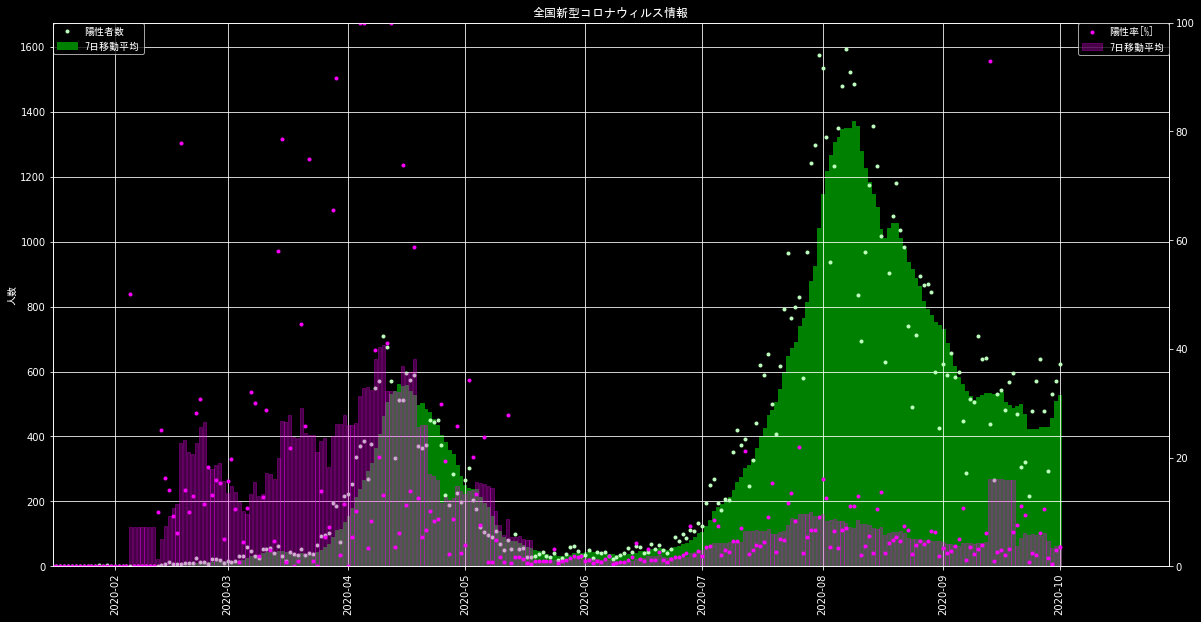

In [510]:
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.plot(xbins, all_data_np[:, offsets['posis']], '.', linewidth=1, color='#c0ffc0')
plt.bar(xbins, posis_mov_mean, color='#008000', edgecolor='#008000', alpha=1)
plt.legend(labels=["陽性者数", "7日移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":fontname})
plt.title('全国新型コロナウィルス情報', fontname=fontname)
ax2 = ax.twinx()
plt.ylim(0, 100)
ax2.plot(xbins, all_data_np[:, offsets['ratio']], '.', linewidth=1, color='#ff00ff')
ax2.bar(xbins, ratio_mov_mean, color='#f000f0', edgecolor='#f000f0', alpha=0.3)
plt.legend(labels=["陽性率[%]", "7日移動平均"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":fontname})
show_and_clear(fig, "mhlw-posis.jpg")

検査人数(移動平均): 29165.285714285714


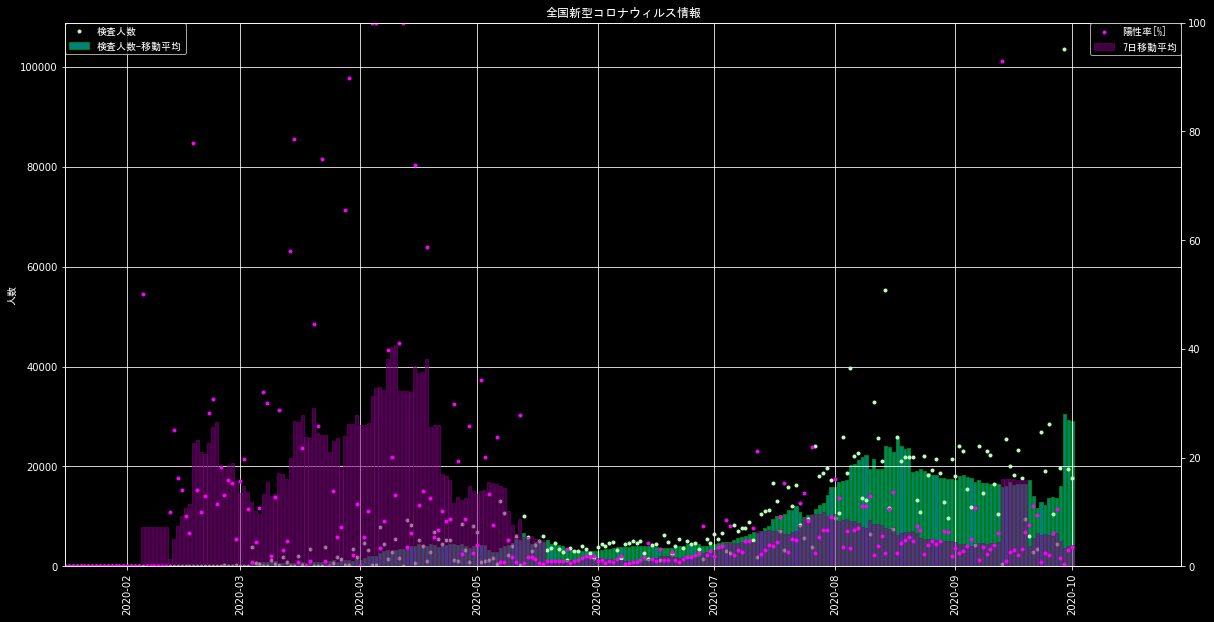

In [511]:
# 移動平均を算出する
tests_mov_mean = moving_average(all_data_np[:, offsets['tests']])
print("検査人数(移動平均): {}".format(tests_mov_mean[-1]))
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.plot(xbins, all_data_np[:, offsets['tests']], '.', linewidth=1, color='#c0ffc0')
plt.bar(xbins, tests_mov_mean, color='#008080', edgecolor='#008000', alpha=1)
plt.legend(labels=["検査人数", "検査人数-移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":fontname})
plt.title('全国新型コロナウィルス情報', fontname=fontname)
ax2 = ax.twinx()
plt.ylim(0, 100)
ax2.plot(xbins, all_data_np[:, offsets['ratio']], '.', linewidth=1, color='#ff00ff')
ax2.bar(xbins, ratio_mov_mean, color='#800080', edgecolor='#800080', alpha=0.5)
plt.legend(labels=["陽性率[%]", "7日移動平均"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":fontname})
show_and_clear(fig, "mhlw-tests.jpg")

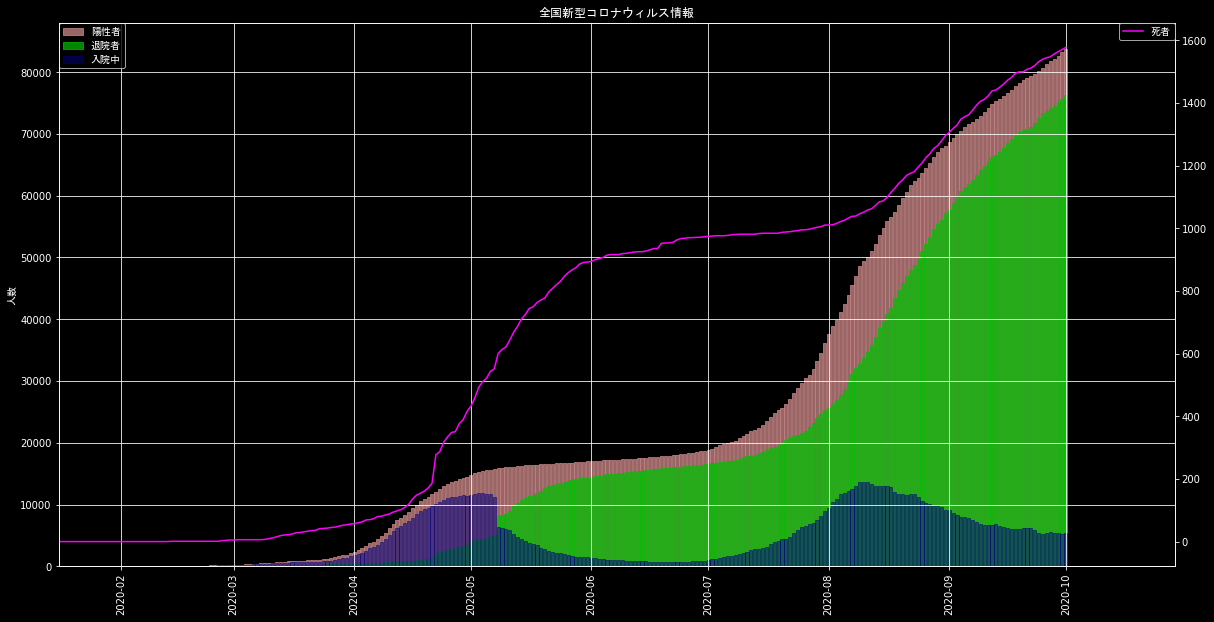

In [505]:
fig, ax = create_basic_plot_figure()
plt.xlim(xbins_pred[0], xbins_pred[-1])
plt.bar(xbins, all_data_np[:, offsets['total']], color='#c08080', edgecolor='#c08080', alpha=.8)
plt.bar(xbins, all_data_np[:, offsets['recov']], color='#00c000', edgecolor='#00c000', alpha=.7)
plt.bar(xbins, all_data_np[:, offsets['cases']], color='#000080', edgecolor='#000080', alpha=.5)
plt.legend(labels=["陽性者", "退院者", "入院中"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":fontname})
plt.title('全国新型コロナウィルス情報', fontname=fontname)
ax2 = ax.twinx()
ax2.plot(xbins, all_data_np[:, offsets['death']], color='magenta', alpha=1)
plt.legend(labels=["死者"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":fontname})
show_and_clear(fig, "mhlw-total.jpg")

In [442]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_total = "全国新型コロナの累計の陽性者・退院者・死者（厚労省 " + today_str + " 現在）"
tw_body_tests = "全国新型コロナの検査人数と陽性率（厚労省 " + today_str + " 現在）"
tw_body_posis = "全国新型コロナの陽性者と陽性率（厚労省 " + today_str + " 現在）"

In [443]:
tw_cfg = yaml.load(open(".tokens"), Loader=yaml.SafeLoader)
tw = Twitter(auth=OAuth(
    tw_cfg['ACCESS_TOKEN'], tw_cfg['ACCESS_TOKEN_SECRET'],
    tw_cfg['CONSUMER_KEY'], tw_cfg['CONSUMER_SECRET']))

In [444]:
if "ipy" not in sys.argv[0]:
    tweet_with_image(tw, "mhlw-posis.jpg", tw_body_posis)
    tweet_with_image(tw, "mhlw-tests.jpg", tw_body_tests)
    tweet_with_image(tw, "mhlw-total.jpg", tw_body_total)